<a href="https://colab.research.google.com/github/bryantanwz/toy-projects/blob/main/FastAI_Cancer_Classifier_FineTunedResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Is it cancer?


In [ ]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

## Step 1: Download images of cancer slides and non-cancer-slides


In [ ]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    with DDGS() as ddgs:
        results = ddgs.images(term, max_results=max_images)
    return L(results).itemgot('image')

Let's start by searching for a cancer photo and seeing what kind of result we get. We'll start by getting URLs from a search:

In [ ]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('cancer histopathology slide photos', max_images=1)
urls[0]

Searching for 'cancer histopathology slide photos'


'https://earimediaprodweb.azurewebsites.net/Api/v1/Multimedia/c3377a35-9d5a-46a0-8d5a-1ed8bf70f190/Rendition/low-res/Content/Public'

...and then download a URL and take a look at it:

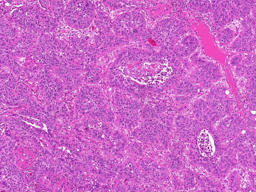

In [ ]:
from fastdownload import download_url
dest = 'cancer.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Now let's do the same with "forest photos":

Searching for 'healthy muscle histopathology photos'


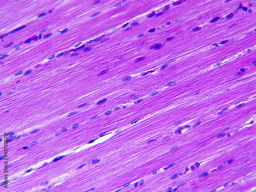

In [ ]:
download_url(search_images('healthy muscle histopathology photos', max_images=1)[0], 'muscle.jpg', show_progress=False)
Image.open('muscle.jpg').to_thumb(256,256)

Our searches seem to be giving reasonable results, so let's grab a few examples of each of "cancer" and "non-cancer" photos, and save each group of photos to a different folder (I'm also trying to grab a range of conditions here):

In [ ]:
searches = 'cancer histopathology slide','healthy muscle histopathology slide'
path = Path('cancer_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'cancer histopathology slide photo'
Searching for 'cancer histopathology slide photo'
Searching for 'cancer histopathology slide photo'
Searching for 'healthy muscle histopathology slide photo'
Searching for 'healthy muscle histopathology slide photo'
Searching for 'healthy muscle histopathology slide photo'


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [ ]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

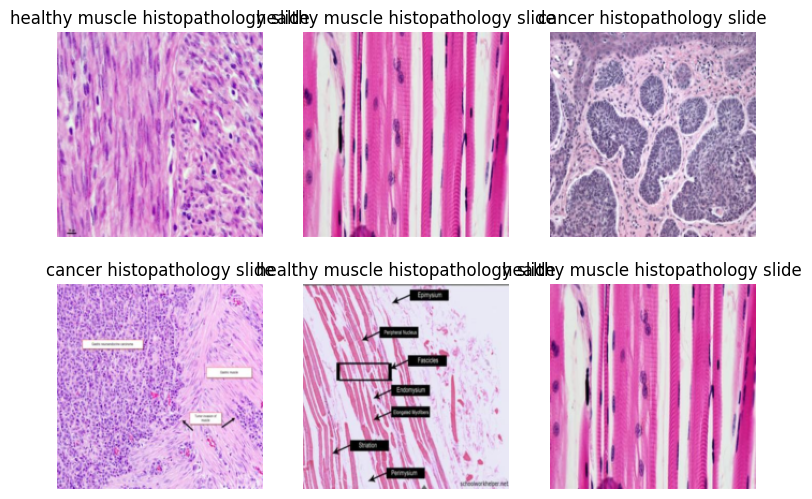

In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

    get_items=get_image_files,

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be *bird* or *forest*).

    item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally takes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 165MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.589354,0.715567,0.461538,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.432230,0.377664,0.192308,00:01
1,0.295050,0.104858,0.038462,00:00
2,0.195772,0.035241,0.000000,00:00


Generally when I run this I see 100% accuracy on the validation set (although it might vary a bit from run to run).

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

## Step 3: Use our model (and build your own!)

Let's see what our model thinks about that bird we downloaded at the start:

This is a: cancer histopathology slide.
Probability it's a cancer: 0.9998


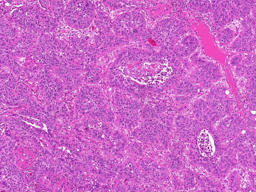

In [ ]:
is_cancer,_,probs = learn.predict(PILImage.create('cancer.jpg'))
print(f"This is a: {is_cancer}.")
print(f"Probability it's a cancer: {probs[0]:.4f}")

Image.open('cancer.jpg').to_thumb(256,256)

This is a: healthy muscle histopathology slide.
Probability it's a cancer: 0.0139


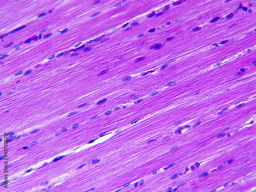

In [ ]:
is_cancer,_,probs = learn.predict(PILImage.create('muscle.jpg'))
print(f"This is a: {is_cancer}.")
print(f"Probability it's a cancer: {probs[0]:.4f}")

Image.open('muscle.jpg').to_thumb(256,256)